In [18]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import torch
import os
import yaml
import cv2
import json
import pandas as pd
import random
import easyocr
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
model_version = 11 # 5 or 11
output_csv_name = 'easy_ocr'

In [20]:
project_dir = os.path.dirname(os.getcwd())
dataset_location = os.path.join(project_dir, 'data', 'ocr_evaluation')
output_location = os.path.join(project_dir, 'data', f'yolo_v{model_version}')
output_name = 'detection_results'

input_img_dir = dataset_location
input_txt_dir = f"{output_location}/{output_name}/labels"
output_dir = f'{output_location}/cropped_plates'


os.makedirs(output_dir, exist_ok=True)

In [21]:
reader = easyocr.Reader(['en'])

In [22]:
source_dataset_location = dataset_location
cropped_dataset_location = output_dir
results_dir = f"{output_location}/ocr_results"
scale_dataset_location = f"{output_location}/scaled_plates"

os.makedirs(results_dir, exist_ok=True)
os.makedirs(scale_dataset_location, exist_ok=True)

In [23]:
for img_file in tqdm(os.listdir(cropped_dataset_location), desc='OCR'):
    if img_file.endswith('jpg'):
        img_path = os.path.join(cropped_dataset_location, img_file)

        img = cv2.imread(img_path)

        output_path = os.path.join(scale_dataset_location, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        result = reader.readtext(output_path)
    
        output_txt_path = os.path.join(results_dir, img_file[:-3]+'json')
        with open(output_txt_path, 'w') as f:
            dict_lst = []
            for (bbox, text, prob) in result:
                dict_lst.append({'Text' : text, 'Probability' : prob})
            json.dump(dict_lst, f)


OCR:   0%|          | 0/386 [00:00<?, ?it/s]

OCR: 100%|██████████| 386/386 [00:23<00:00, 16.50it/s]


## 4. Evaluating OCR Results

We load the ground truth data from a CSV file.

In [24]:
df_true_location = f'{dataset_location}/output.csv'
df_true = pd.read_csv(df_true_location)
df_true['picture_name'] = df_true['picture_name'].apply(lambda x: 'plate_'+x)
df_true.set_index('picture_name', inplace=True)
df_true.head()

,text
picture_name,
plate_00808.jpg,046TS
plate_01433.jpg,912FB
plate_01063.jpg,044FF
plate_01576.jpg,M496T
plate_00263.jpg,155DW


In [25]:
df_pred_location = f'{output_location}/{output_csv_name}_pred.csv'
plate_numbers = []
plate_strings = []

threshold = 0.6

for ocr_file in os.listdir(results_dir):
    with open(os.path.join(results_dir, ocr_file), 'r') as f:
        plt_str = ''
        results = json.load(f)
        for result in results:
            if float(result['Probability']) > threshold:
                plt_str += result['Text']
        plt_str = plt_str.replace(" ", "").upper()
        plate_strings.append(plt_str)
        plate_numbers.append(ocr_file.split('.')[0]+'.jpg')

df_pred = pd.DataFrame({'picture_name':plate_numbers, 'text':plate_strings})
df_pred.to_csv(df_pred_location)
df_pred.set_index('picture_name', inplace=True)
df_pred.head()

,text
picture_name,
plate_01772.jpg,
plate_00694.jpg,6238BG
plate_00978.jpg,197WP
plate_01461.jpg,881
plate_00857.jpg,4659HY


We evaluate the OCR performance using accuracy, Levenshtein ratio, and character-level precision, recall, and F1 score.

In [26]:
import pandas as pd
from difflib import SequenceMatcher
from sklearn.metrics import f1_score, precision_score, recall_score

# Merging dataframes on 'picture_name' index to only evaluate overlapping entries
df_merged = df_true.join(df_pred, lsuffix='_true', rsuffix='_pred', how='inner')

# 1. Accuracy (Exact Match)
exact_matches = (df_merged['text_true'] == df_merged['text_pred']).sum()
accuracy = exact_matches / len(df_merged)

# 2. Levenshtein Distance (Edit Distance) - Using SequenceMatcher
def levenshtein_ratio(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()

df_merged['levenshtein_ratio'] = df_merged.apply(lambda row: levenshtein_ratio(row['text_true'], row['text_pred']), axis=1)
average_levenshtein_ratio = df_merged['levenshtein_ratio'].mean()

# 3. Character-Level Precision, Recall, F1 Score
def calculate_char_level_scores(true_text, pred_text):
    # Creating sets of characters for precision, recall, F1
    true_chars = set(true_text)
    pred_chars = set(pred_text)
    
    true_positive = len(true_chars & pred_chars)
    precision = true_positive / len(pred_chars) if pred_chars else 0
    recall = true_positive / len(true_chars) if true_chars else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

# Calculate character-level scores for each entry
df_merged[['char_precision', 'char_recall', 'char_f1']] = df_merged.apply(
    lambda row: pd.Series(calculate_char_level_scores(row['text_true'], row['text_pred'])), axis=1
)

# Aggregate the results
average_precision = df_merged['char_precision'].mean()
average_recall = df_merged['char_recall'].mean()
average_f1_score = df_merged['char_f1'].mean()

# Output results
print(f"Accuracy (Exact Match): {accuracy:.2f}")
print(f"Average Levenshtein Ratio: {average_levenshtein_ratio:.2f}")
print(f"Character-Level Precision: {average_precision:.2f}")
print(f"Character-Level Recall: {average_recall:.2f}")
print(f"Character-Level F1 Score: {average_f1_score:.2f}")

df_merged_loaction = f'{output_location}/merged.csv'
df_merged.to_csv(df_merged_loaction)

Accuracy (Exact Match): 0.08
Average Levenshtein Ratio: 0.41
Character-Level Precision: 0.52
Character-Level Recall: 0.42
Character-Level F1 Score: 0.44


### Plate examples

{'Text': '4242', 'Probability': 0.5434389700645614}
{'Text': 'TV', 'Probability': 0.6430899011268701}


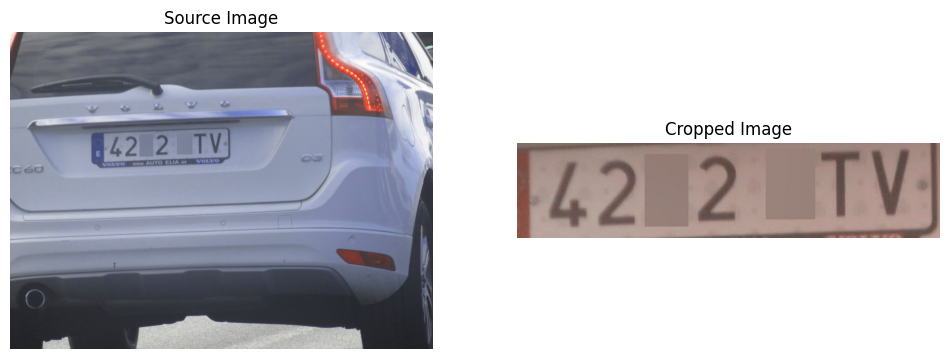

{'Text': 'SP', 'Probability': 0.9804587042294697}
{'Text': '1020', 'Probability': 0.9968814849853516}


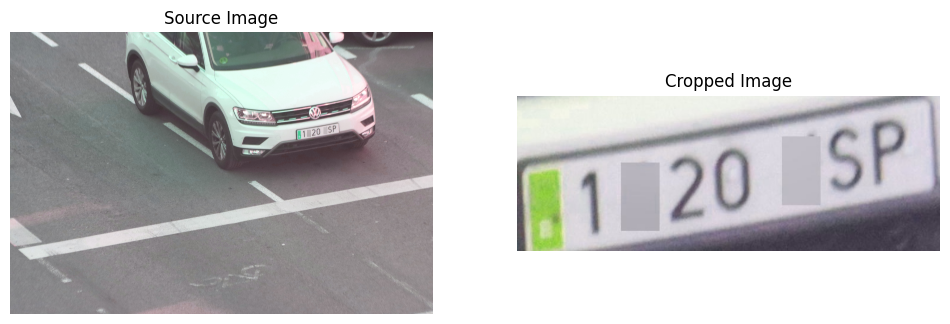

{'Text': 'M', 'Probability': 0.9194603558754011}
{'Text': '2', 'Probability': 0.9704827847265882}
{'Text': '218_', 'Probability': 0.3038179361471714}


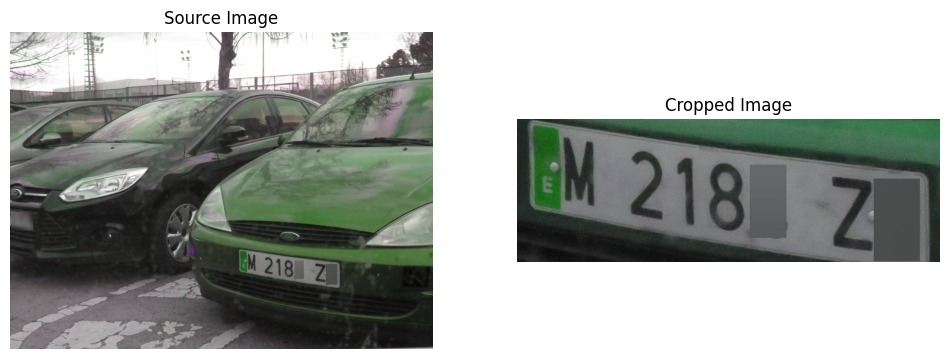

{'Text': '4014', 'Probability': 0.4163243770599365}
{'Text': 'PP', 'Probability': 0.910271560997555}


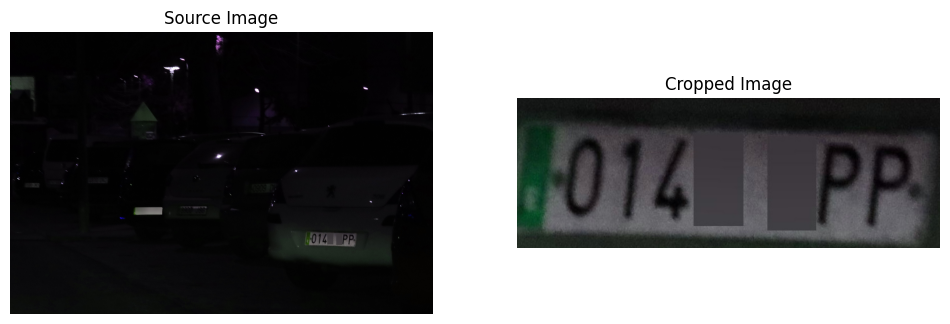

{'Text': '83 ', 'Probability': 0.8499158747620258}
{'Text': 'DT', 'Probability': 0.849344501482112}
{'Text': '130o', 'Probability': 0.010472872294485569}


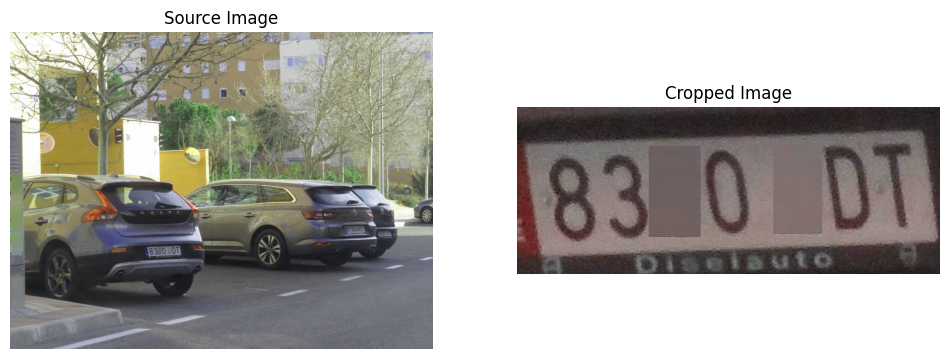

{'Text': 'UH', 'Probability': 0.05068408192519196}
{'Text': 'DSRl', 'Probability': 0.10565001517534256}
{'Text': '488', 'Probability': 0.9716547278755567}


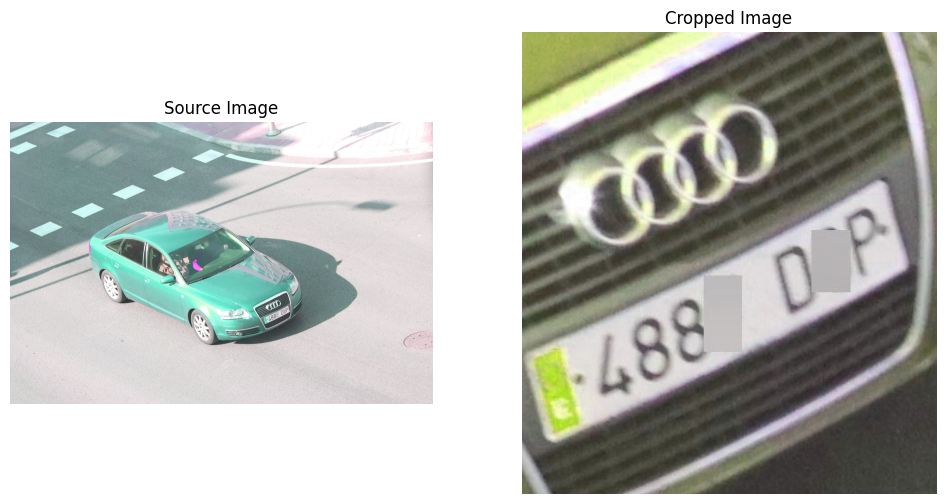

{'Text': '06', 'Probability': 0.9368129829973842}
{'Text': '2 Lcz', 'Probability': 0.6706542286593833}


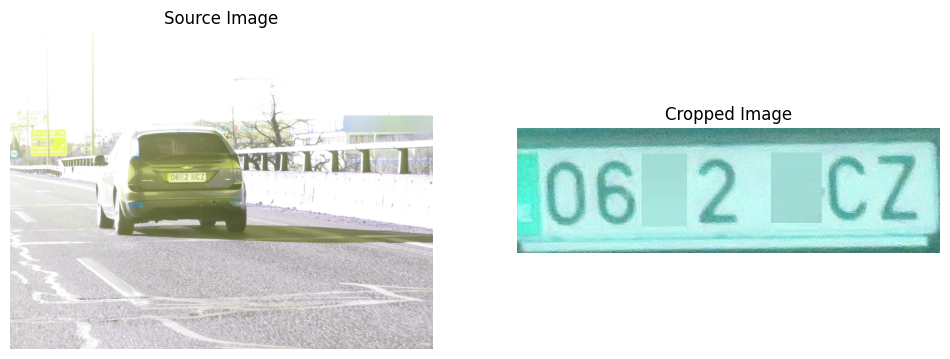

{'Text': '8', 'Probability': 0.9995865057277662}
{'Text': 'GR', 'Probability': 0.9936949371798831}
{'Text': '93 E', 'Probability': 0.27700558200463204}


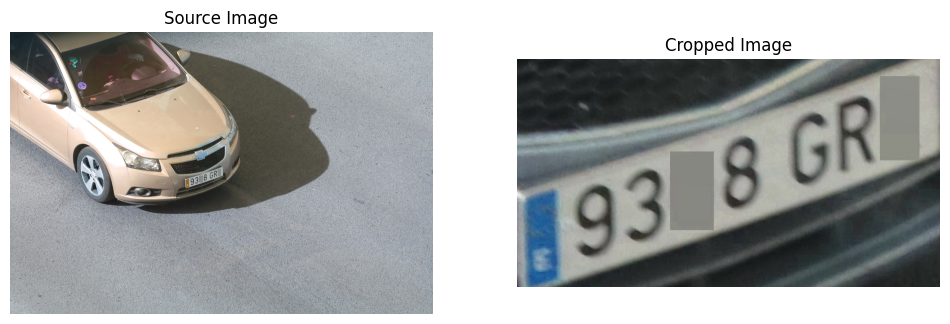

{'Text': 'JX', 'Probability': 0.7637755941399426}
{'Text': '5415', 'Probability': 0.16638241708278656}


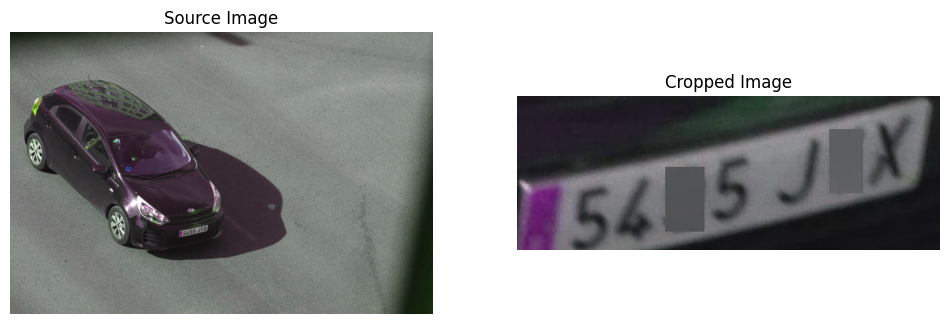

{'Text': '76176 FLN', 'Probability': 0.9374761108977481}


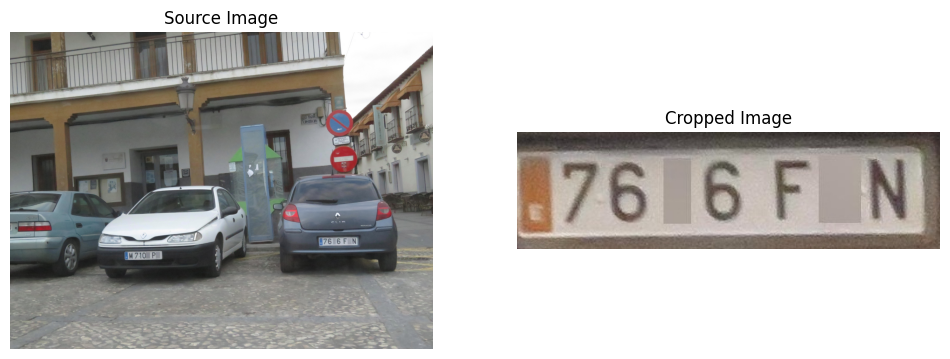

In [27]:
import random

first_dataset = source_dataset_location
second_dataset = scale_dataset_location

# start_index = 0
start_index = random.randint(0, len(os.listdir(second_dataset)))

for img_file in os.listdir(second_dataset)[start_index:start_index+10]:
    if img_file.endswith('jpg'):
        cropped_img_path = os.path.join(second_dataset, img_file)
        source_img_path = os.path.join(first_dataset, img_file[6:])
        results_path = os.path.join(results_dir, img_file[:-3]+'json')

        cropped_img = cv2.imread(cropped_img_path)
        source_img = cv2.imread(source_img_path)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        source_img_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
        
        with open(results_path, 'r') as f:
            results = json.load(f)
            for result in results:
                print(result)
        
        # Plot images and results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(source_img_rgb)
        axes[0].set_title('Source Image')
        axes[0].axis('off')
        
        axes[1].imshow(cropped_img_rgb)
        axes[1].set_title('Cropped Image')
        axes[1].axis('off')
        
        plt.show()